# Gaussian Process Regression

Gaussian Process regression is a non-parametric approach to regression or data fitting that assumes that observed data points $y$ are generated by some unknown latent function $f(x)$.  The latent function $f(x)$ is modeled as being multivariate normally distributed (a Gaussian Process), and is commonly denoted

\begin{equation}
f(x) \sim \mathcal{GP}(m(x;\theta), \, k(x, x';\theta)) \,.
\end{equation}

$m(x ; \theta)$ is the *mean function*, and $k(x, x' ;\theta)$ is the covariance function.  In many applications, the mean function is set to $0$ because the data can still be fit well using just covariances.  

$\theta$ is the set of *hyperparameters* for either the mean or covariance function.  These are the unknown variables.  They are usually found by maximizing the marginal likelihood.  This approach is much faster computationally than MCMC, but produces a point estimate, $\theta_{\mathrm{MAP}}$.  

The data in the next two examples is generated by a GP with noise that is also gaussian distributed.  In sampling notation this is,

\begin{equation}
\begin{aligned}
y & = f(x) + \epsilon \\
f(x) & \sim \mathcal{GP}(0, \, k(x, x'; \theta)) \\
\epsilon & \sim \mathcal{N}(0, \sigma^2) \\
\sigma^2 & \sim \mathrm{Prior} \\
\theta & \sim \mathrm{Prior} \,.
\end{aligned}
\end{equation}

With Theano as a backend, PyMC3 is an excellent environment for developing fully Bayesian Gaussian Process models, particularly when a GP is component in a larger model.  The GP functionality of PyMC3 is meant to be lightweight, highly composable, and have a clear syntax.  This example is meant to give an introduction to how to specify a GP in PyMC3.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg 
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

## Example 1: Non-Linear Regression

This is an example of a non-linear fit in a situation where there isn't much data.  Using optimization to find hyperparameters in this situation will greatly underestimate the amount of uncertainty if using the GP for prediction.  In PyMC3 it is easy to be fully Bayesian and use MCMC methods.

We generate 20 data points at random ```x``` values between 0 and 3.  The true values of the hyperparameters are hardcoded in this temporary ```model```. 

In [2]:
np.random.seed(20090425)
n = 20
X = np.sort(3*np.random.rand(n))[:,None]

with pm.Model() as model:
    # f(x)
    l_true = 0.3
    s2_f_true = 1.0
    cov = s2_f_true * pm.gp.cov.ExpQuad(1, l_true)
    
    # noise, epsilon
    s2_n_true = 0.1
    K_noise = s2_n_true**2 * tt.eye(n)
    K = cov(X) + K_noise   

# evaluate the covariance with the given hyperparameters
K = theano.function([], cov(X) + K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
y = np.random.multivariate_normal(np.zeros(n), K)

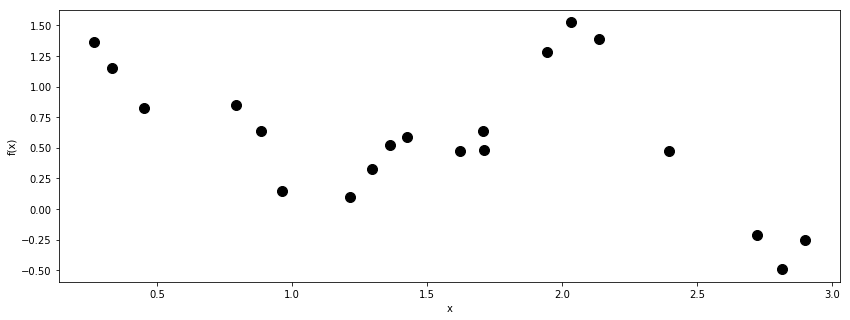

In [3]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

Since there isn't much data, there will likely be a lot of uncertainty in the hyperparameter values.

### The Model

- We assign prior distributions that are uniform in log space, suitable for variance-type parameters.  Each hyperparameter must at least be constrained to be positive valued by its prior.  

- None of the covariance function objects have a scaling coefficient built in.  This is because random variables, such as ```s2_f```, can be multiplied directly with a covariance function object, ```gp.cov.ExpQuad```.  

- The last line is the *marginal* likelihood.  Since the observed data $y$ is also assumed to be multivariate normally distributed, the marginal likelihood is also multivariate normal.  It is obtained by integrating out $f(x)$ from the product of the data likelihood $p(y \mid f, X)$ and the GP prior $p(f \mid X)$,

\begin{equation}
p(y \mid X) = \int p(y \mid f, X) p(f \mid X) df
\end{equation}

- The call in the last line ```f_cov.K(X)``` evaluates the covariance function across the inputs ```X```.  The result is a matrix.  The sum of this matrix and the diagonal noise term are used as the covariance matrix for the marginal likelihood.  

In [4]:
Z = np.linspace(0,3,100)[:,None]

with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.Uniform('l', 0, 10)
    
    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    
    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    
    # covariance functions for the function f and the noise 
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)
    
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':y})

In [5]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -22.818: 100%|██████████| 200000/200000 [00:43<00:00, 4605.11it/s]
Finished [100%]: Average ELBO = -22.857
100%|██████████| 2000/2000 [00:18<00:00, 109.41it/s]


The results show that the hyperparameters were recovered pretty well, but definitely with a high degree of uncertainty. Lets look at the predicted fits and uncertainty next using samples from the full posterior. 

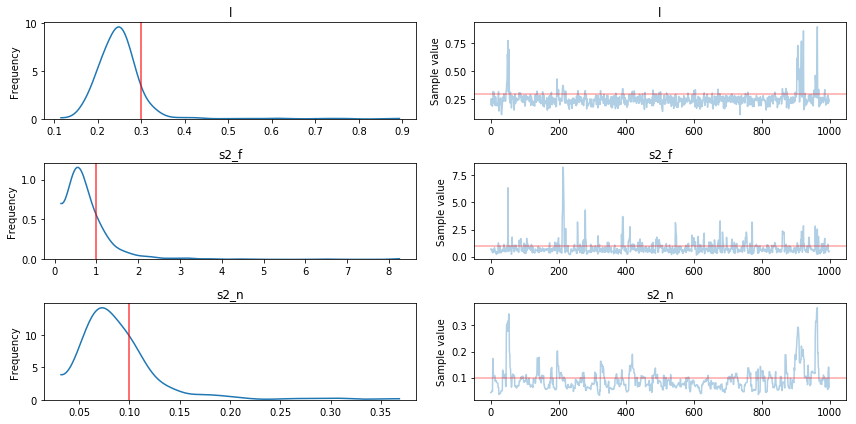

In [6]:
pm.traceplot(trace[1000:], varnames=['l', 's2_f', 's2_n'], 
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

The `sample_gp` function draws realizations of the GP from the predictive distribution.

In [7]:
with model:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_obs, Z, samples=50, random_seed=42)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 50/50 [00:03<00:00, 16.24it/s]


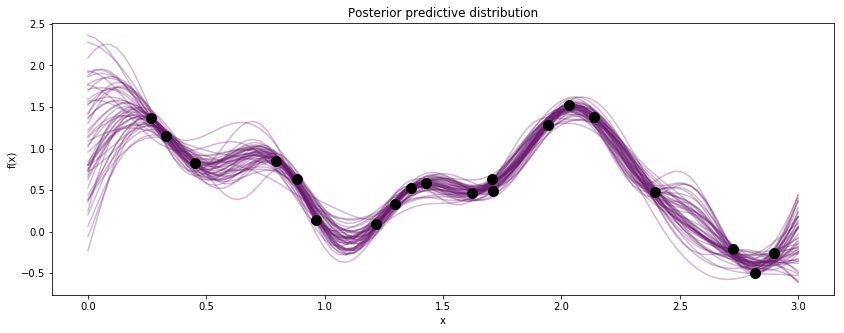

In [8]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

## Example 2: A periodic signal in non-white noise

This time let's pretend we have some more complex data that we would like to decompose.  For the sake of example, we simulate some data points from a function that 
1. has a fainter periodic component
2. has a lower frequency drift away from periodicity
3. has additive white noise

As before, we generate the data using a throwaway PyMC3 ```model```.  We consider the sum of the drift term and the white noise to be "noise", while the periodic component is "signal".  In GP regression, the treatment of signal and noise covariance functions is identical, so the distinction between signal and noise is somewhat arbitrary.

In [2]:
np.random.seed(200)
n = 150
X = np.sort(40*np.random.rand(n))[:,None]

# define gp, true parameter values
with pm.Model() as model:
    l_per_true = 2
    cov_per = pm.gp.cov.Cosine(1, l_per_true)

    l_drift_true = 4
    cov_drift = pm.gp.cov.Matern52(1, l_drift_true)
    
    s2_p_true = 0.3
    s2_d_true = 1.5
    s2_w_true = 0.3
    
    periodic_cov = s2_p_true * cov_per
    drift_cov    = s2_d_true * cov_drift
    
    signal_cov   = periodic_cov + drift_cov
    noise_cov    = s2_w_true**2 * tt.eye(n)
    
    
K = theano.function([], signal_cov(X, X) + noise_cov)()
y = np.random.multivariate_normal(np.zeros(n), K)

In the plot of the observed data, the periodic component is barely distinguishable by eye.  It is plausible that there isn't a periodic component, and the observed data is just the drift component and white noise.  

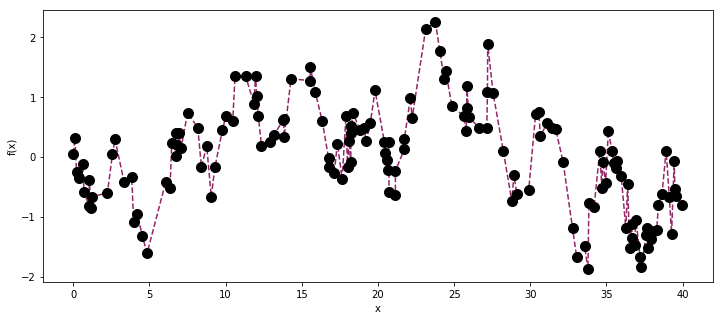

In [3]:
fig = plt.figure(figsize=(12,5)); ax = fig.add_subplot(111)
ax.plot(X, y, '--', color=cm(0.4))
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

Lets see if we can infer the correct values of the hyperparameters.

In [4]:
with pm.Model() as model:
    # prior for periodic lengthscale, or frequency 
    l_per = pm.Uniform('l_per', lower=1e-5, upper=10)

    # prior for the drift lengthscale hyperparameter
    l_drift  = pm.Uniform('l_drift', lower=1e-5, upper=10)
    
    # uninformative prior on the periodic amplitude
    log_s2_p = pm.Uniform('log_s2_p', lower=-10, upper=5)
    s2_p = pm.Deterministic('s2_p', tt.exp(log_s2_p))
    
    # uninformative prior on the drift amplitude
    log_s2_d = pm.Uniform('log_s2_d', lower=-10, upper=5)
    s2_d = pm.Deterministic('s2_d', tt.exp(log_s2_d))
    
    # uninformative prior on the white noise variance
    log_s2_w = pm.Uniform('log_s2_w', lower=-10, upper=5)
    s2_w = pm.Deterministic('s2_w', tt.exp(log_s2_w))
    
    # the periodic "signal" covariance
    signal_cov = s2_p * pm.gp.cov.Cosine(1, l_per)
    
    # the "noise" covariance
    drift_cov  = s2_d * pm.gp.cov.Matern52(1, l_drift)
    
    y_obs = pm.gp.GP('y_obs', cov_func=signal_cov + drift_cov, sigma=s2_w, observed={'X':X, 'Y':y})

In [5]:
with model:
    trace = pm.sample(20000, step=pm.Metropolis())

100%|██████████| 20000/20000 [07:06<00:00, 46.85it/s]


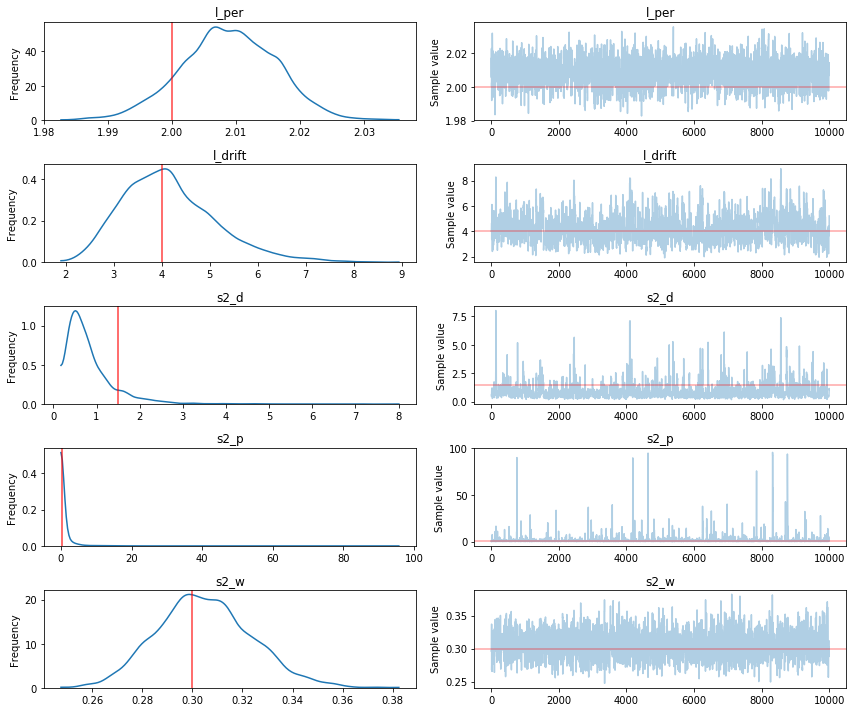

In [8]:
pm.traceplot(trace[10000:], varnames=['l_per', 'l_drift', 's2_d', 's2_p', 's2_w'], 
            lines={"l_per": l_per_true, 
                   "l_drift": l_drift_true, 
                   "s2_d":    s2_d_true, 
                   "s2_p":    s2_p_true,
                   "s2_w":    s2_w_true});

Some large samples make the histogram of ```s2_p``` hard to read.  Below is a zoomed in histogram.

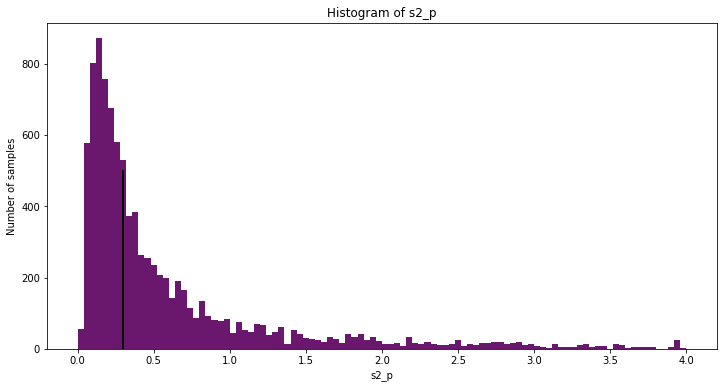

In [9]:
fig = plt.figure(figsize=(12,6)); ax = fig.add_subplot(111)
ax.hist(trace['s2_p', 10000:], 100, range=(0,4), color=cm(0.3), ec='none');
ax.plot([0.3, 0.3], [0, 500], "k", lw=2);
ax.set_title("Histogram of s2_p");
ax.set_ylabel("Number of samples");
ax.set_xlabel("s2_p");

Comparing the histograms of the results to the true values, we can see that the PyMC3's MCMC methods did a good job estimating the true GP hyperparameters.  Although the periodic component is faintly apparent in the observed data, the GP model is able to extract it with high accuracy.  